In [1]:
import pandas as pd
train_dataset = pd.read_csv('../corpus-raymond/usecase-train-hf.csv')
val_dataset = pd.read_csv('../corpus-raymond/usecase-val-hf.csv')
test_dataset = pd.read_csv('../corpus-raymond/usecase-test-hf.csv')
#take column 'tokens' as list
train_dataset['tokens'] = train_dataset['tokens'].apply(eval)
val_dataset['tokens'] = val_dataset['tokens'].apply(eval)
test_dataset['tokens'] = test_dataset['tokens'].apply(eval)

#take column 'IOB_tag' as list
train_dataset['IOB_tag'] = train_dataset['IOB_tag'].apply(eval)
val_dataset['IOB_tag'] = val_dataset['IOB_tag'].apply(eval)
test_dataset['IOB_tag'] = test_dataset['IOB_tag'].apply(eval)


In [2]:
!python --version

Python 3.11.11


In [3]:
# First define your standard IOB tags
iob_mapping = {
    "O": 0,
    "B-actor": 1,
    "I-actor": 2,
    "B-usecase": 3,
    "I-usecase": 4
}

# Create label names list including a special PAD token
label_names = ['O', 'B-actor', 'I-actor', 'B-usecase', 'I-usecase', '[PAD]']

# Define id2label and label2id including the PAD token
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

# Define pad token label id as the last index (safer than -100 for CUDA)
pad_token_label_id = label2id['[PAD]']

In [4]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
print(id2label)
print(label2id)

{0: 'O', 1: 'B-actor', 2: 'I-actor', 3: 'B-usecase', 4: 'I-usecase', 5: '[PAD]'}
{'O': 0, 'B-actor': 1, 'I-actor': 2, 'B-usecase': 3, 'I-usecase': 4, '[PAD]': 5}


In [5]:
words = train_dataset.iloc[0]["tokens"]
labels = train_dataset.iloc[0]["IOB_tag"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(words)
print(labels)

['Administrator', 'clicks', 'the', 'button', 'or', 'link', 'to', '"', 'Install', 'Plug', '-', 'ins', '"']
[1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0]


In [6]:
from transformers import AutoTokenizer, DebertaV2TokenizerFast
import os
from pathlib import Path
tokenizer_checkpoint = "microsoft/deberta-v3-base"
model_checkpoint = "microsoft/deberta-v3-base" 
folder_name = "BERT-Style-result/microsoft/pdeberta-v3-base-4-epoch-8bs-new"
model_name_save = "BERT-Style-model/microsoft/deberta-v3-base-4-epoch-8bs-new"
Path(folder_name).mkdir(parents=True, exist_ok=True)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint, add_prefix_space=True )

max_length = 256
epochs = 4
bs = 8

/usr/local/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [7]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            # Use pad_token_label_id for special tokens (None)
            label = pad_token_label_id if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(pad_token_label_id)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [8]:
inputs = tokenizer(train_dataset.iloc[0]["tokens"],truncation=True, is_split_into_words=True, padding='do_not_pad', max_length=max_length)
labels = train_dataset.iloc[0]["IOB_tag"]
word_ids = inputs.word_ids()
print(inputs)
# print(labels)
# print(align_labels_with_tokens(labels, word_ids))

{'input_ids': [1, 13988, 13439, 262, 1946, 289, 1321, 264, 307, 12869, 19115, 341, 267, 268, 307, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [9]:
def tokenize_and_align_labels(df):
    # Convert Pandas DataFrame to dictionary format (column-based)
    examples = df.to_dict(orient="list")

    # Tokenize the input tokens
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, padding='max_length', max_length=max_length
    )

    all_labels = examples["IOB_tag"]
    rearranged_labels = []

    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        rearranged_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = rearranged_labels
    return tokenized_inputs


In [10]:
tokenized_train = tokenize_and_align_labels(train_dataset)
tokenized_val = tokenize_and_align_labels(val_dataset)
tokenized_test = tokenize_and_align_labels(test_dataset)

In [11]:
from datasets import Dataset
# convert tokenized train to arrow dataset class
train_dataset = Dataset.from_dict(tokenized_train)
val_dataset = Dataset.from_dict(tokenized_val)
test_dataset = Dataset.from_dict(tokenized_test)

# Data Collation

In [12]:
# from transformers import DataCollatorForTokenClassification

# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Metrics

In [13]:
import evaluate

metric = evaluate.load("seqeval")

Using the latest cached version of the module from /root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--seqeval/541ae017dc683f85116597d48f621abc7b21b88dc42ec937c71af5415f0af63c (last modified on Fri Mar  7 07:23:39 2025) since it couldn't be found locally at evaluate-metric--seqeval, or remotely on the Hugging Face Hub.


In [14]:
import numpy as np

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove PAD tokens and convert to labels
    true_labels = []
    true_predictions = []
    
    for i in range(len(labels)):
        seq_true_labels = []
        seq_true_preds = []
        
        for j in range(len(labels[i])):
            if labels[i][j] != pad_token_label_id:
                # Only include non-PAD tokens
                seq_true_labels.append(label_names[labels[i][j]])
                seq_true_preds.append(label_names[predictions[i][j]])
        
        true_labels.append(seq_true_labels)
        true_predictions.append(seq_true_preds)
    
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

# Defining the model

In [15]:
from torch.optim import AdamW
from transformers import AutoModelForTokenClassification, AutoModelForSeq2SeqLM
import torch.nn as nn
import torch.nn.functional as F
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, pad_token_id=5, smoothing=0.0):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.pad_token_id = pad_token_id  # Use the pad token ID you defined
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, logits, target):
        # Create a mask for pad tokens
        pad_mask = (target == self.pad_token_id)
        
        # Reshape logits for CrossEntropyLoss (batch_size * seq_len, num_classes)
        logits_flat = logits.view(-1, logits.size(-1))
        
        # Reshape target for CrossEntropyLoss (batch_size * seq_len)
        target_flat = target.view(-1)
        
        # Convert pad tokens to 0 temporarily for valid indexing, we'll ignore them with the mask
        target_flat = torch.where(target_flat == self.pad_token_id, 
                                  torch.tensor(0, device=target.device), 
                                  target_flat)
        
        # Standard CrossEntropy calculation
        loss = F.cross_entropy(logits_flat, target_flat, reduction='none')
        
        # Reshape pad_mask to match loss dimensions
        pad_mask_flat = pad_mask.view(-1)
        
        # Zero out the loss for pad tokens (we don't want to train on those)
        masked_loss = torch.where(pad_mask_flat, 
                                  torch.tensor(0.0, device=loss.device), 
                                  loss)
        
        # Calculate mean over non-pad tokens
        non_pad_elements = (~pad_mask_flat).sum().float()
        if non_pad_elements > 0:
            return masked_loss.sum() / non_pad_elements
        else:
            return torch.tensor(0.0, device=masked_loss.device)

class CustomTokenClassificationModel(nn.Module):
    def __init__(self, base_model, num_labels, pad_token_label_id):
        super(CustomTokenClassificationModel, self).__init__()
        self.base_model = base_model
        self.pad_token_label_id = pad_token_label_id
        self.num_labels = num_labels
        
    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        
        logits = outputs.logits
        
        loss = None
        if labels is not None:
            # Use custom loss function to ignore pad tokens
            loss_fct = LabelSmoothingCrossEntropy(pad_token_id=self.pad_token_label_id)
            loss = loss_fct(logits, labels)
        
        return (loss, logits) if loss is not None else logits

# Load the base model for token classification
base_model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    num_labels=len(label_names),  # Include PAD in num_labels
    ignore_mismatched_sizes=True
)

# Wrap it in our custom model
model = CustomTokenClassificationModel(base_model, len(label_names), pad_token_label_id)

# weight_decay is a regularization procedure with regard to the weight matrices
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.base_model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

# Adam optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import torch

device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
# device = "cuda"
print(device)
model.to(device)

cuda:1


CustomTokenClassificationModel(
  (base_model): DebertaV2ForTokenClassification(
    (deberta): DebertaV2Model(
      (embeddings): DebertaV2Embeddings(
        (word_embeddings): Embedding(128100, 768, padding_idx=0)
        (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): DebertaV2Encoder(
        (layer): ModuleList(
          (0-11): 12 x DebertaV2Layer(
            (attention): DebertaV2Attention(
              (self): DisentangledSelfAttention(
                (query_proj): Linear(in_features=768, out_features=768, bias=True)
                (key_proj): Linear(in_features=768, out_features=768, bias=True)
                (value_proj): Linear(in_features=768, out_features=768, bias=True)
                (pos_dropout): Dropout(p=0.1, inplace=False)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): DebertaV2SelfOutput(
                (dense): Li

# Preparing Fine Tuning

In [17]:
# Convert the dataset to torch tensors
train_inputs = torch.tensor(train_dataset["input_ids"])
dev_inputs = torch.tensor(val_dataset["input_ids"])
test_inputs = torch.tensor(test_dataset["input_ids"])
train_tags = torch.tensor(train_dataset["labels"])
dev_tags = torch.tensor(val_dataset["labels"])
test_tags = torch.tensor(test_dataset["labels"])
train_masks = torch.tensor(train_dataset["attention_mask"])
dev_masks = torch.tensor(val_dataset["attention_mask"])
test_masks = torch.tensor(test_dataset["attention_mask"])

In [18]:
from torch.utils.data import TensorDataset, RandomSampler, DataLoader, SequentialSampler

# We define the dataloaders. 
# Shuffle the data for training using RandomSampler
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Load dev and test data sequentially with SequentialSampler.
dev_data = TensorDataset(dev_inputs, dev_masks, dev_tags)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [19]:
# Import a scheduler to reduce the learning rate 
from transformers import get_linear_schedule_with_warmup

# Number of training epochs; the BERT paper uses 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training

In [20]:
from sklearn.metrics import f1_score
from tqdm import trange

# To measure execution time of this cell

# Train the model for; the BERT paper uses 4
## Store the average loss after each epoch; these values are used to plot the loss.
loss_values, development_loss_values = [], []


for _ in trange(epochs, desc="Epoch"):
    #
    # Training
    #
    # Set the model into training mode
    model.train()
    # Reset the total loss for each epoch
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Transfer batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Remove previous gradients before each backward pass
        model.zero_grad()
        # forward pass
        # This returns the loss (not the model output) since we have input the labels.
        outputs = model(input_ids=b_input_ids,
                        attention_mask=b_input_mask, labels=b_labels)
        # Get the loss
        loss = outputs[0]
        # Backward pass to compute the gradients
        loss.backward()
        # Train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # Update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    

    # Store each loss value for plotting the learning curve afterwards
    loss_values.append(avg_train_loss)

    # After each training epoch, measure performance on development set

    # Set the model into evaluation mode
    model.eval()
    # Reset the development loss for this epoch
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []
    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # The model must not compute or save gradients, in order to save memory and speed up this step
        with torch.no_grad():
            # Forward pass, compute predictions
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # Transfer logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Compute the accuracy for this batch of development sentences
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
    
    eval_loss = eval_loss / len(dev_dataloader)
    development_loss_values.append(eval_loss)
    print("Development loss: {}".format(eval_loss))
    
    # Filter out pad tokens when computing metrics
    pred_tags = []
    dev_tags = []
    
    for p, l in zip(predictions, true_labels):
        for p_i, l_i in zip(p, l):
            if l_i != pad_token_label_id:  # Only include non-pad tokens
                pred_tags.append(label_names[p_i])
                dev_tags.append(label_names[l_i])
    
    f1 = f1_score(dev_tags, pred_tags, average='micro')

    # Format output with 4 decimal places
    output_text = "train-val F1 score: {:.4f}\n".format(f1)

    # Print to console
    print(output_text)

    # Save to a text file
    with open(folder_name + "/f1_score.txt", "a") as file:
        file.write(output_text)
    
    print()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Average train loss: 0.15018294875925356


Epoch:  25%|██▌       | 1/4 [00:46<02:19, 46.63s/it]

Development loss: 0.0680281653185375
train-val F1 score: 0.9852


Average train loss: 0.07393748725990991


Epoch:  50%|█████     | 2/4 [01:32<01:32, 46.31s/it]

Development loss: 0.06824522025999613
train-val F1 score: 0.9810


Average train loss: 0.04939666709754886


Epoch:  75%|███████▌  | 3/4 [02:18<00:46, 46.30s/it]

Development loss: 0.0635192078370892
train-val F1 score: 0.9845


Average train loss: 0.03195182002594732


Epoch: 100%|██████████| 4/4 [03:05<00:00, 46.38s/it]

Development loss: 0.0690889940597117
train-val F1 score: 0.9832




In [21]:
df = pd.DataFrame(list(zip(pred_tags, dev_tags)),
               columns =['Pred', 'True'])
df.to_csv(folder_name + '/train-val-result-bert.csv')

# Visualize

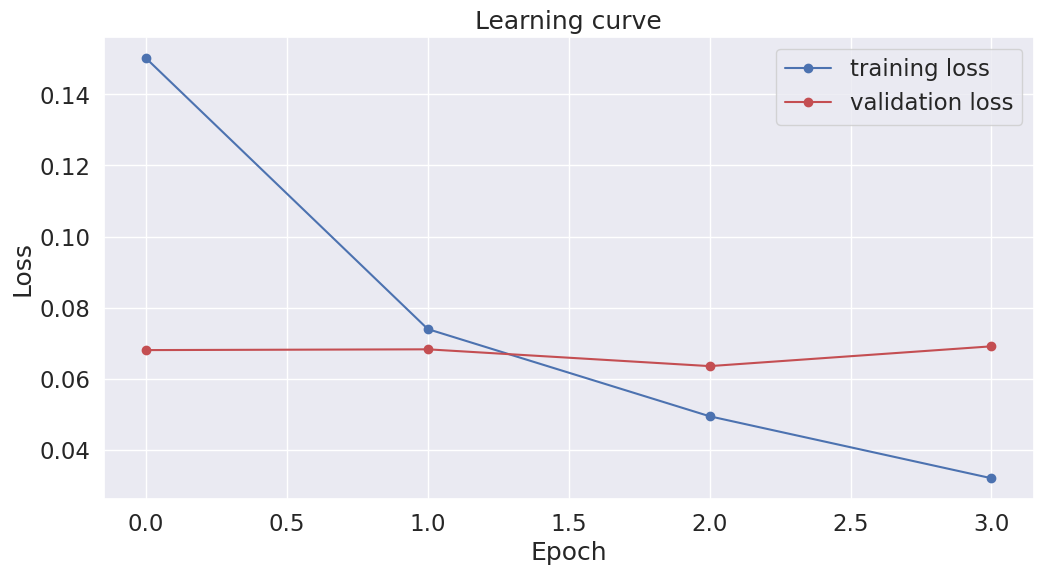

In [22]:
# Plot the training loss
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(development_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Testing  

In [23]:
# Apply the model to the test set with PAD token prediction prevention
# Set again the model into evaluation mode
model.eval()
nb_eval_steps, nb_eval_examples = 0, 0
predictions, true_labels = [], []

input_ids_list = []
eval_loss = 0

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # The model must not compute or store gradients
    with torch.no_grad():
        # Get loss
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        eval_loss += outputs[0].mean().item()
        
        # Use the predict_without_pad function to get predictions (avoiding PAD predictions)
        batch_preds = predict_without_pad(model, b_input_ids, b_input_mask, pad_token_label_id)
        batch_preds = batch_preds.detach().cpu().numpy()
    
    # Transfer labels to CPU
    label_ids = b_labels.to('cpu').numpy()
    input_ids_list.extend(b_input_ids)
    
    predictions.extend([list(p) for p in batch_preds])
    true_labels.extend(label_ids)

# Filter out pad tokens when computing metrics
pred_tags = []
test_tags = []

for p, l in zip(predictions, true_labels):
    for p_i, l_i in zip(p, l):
        if l_i != pad_token_label_id:  # Only include non-pad tokens
            # No need to check if p_i == pad_token_label_id because our prediction function prevents this
            pred_tags.append(label_names[p_i])
            test_tags.append(label_names[l_i])

f1 = f1_score(test_tags, pred_tags, average='micro')

# Format output with 4 decimal places
output_text = "Test F1 score (with PAD prevention): {:.4f}\n".format(f1)

# Print to console
print(output_text)

# Save to a text file
with open(folder_name + "/f1_score.txt", "a") as file:
    file.write(output_text)

print()

NameError: name 'predict_without_pad' is not defined

In [ ]:
df = pd.DataFrame(list(zip(pred_tags, test_tags)),
               columns =['Pred', 'True'])
df.to_csv(folder_name + '/test-result-bert.csv')

In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Load the CSV file
df = pd.read_csv(folder_name+"/test-result-bert.csv")

# Extract true and predicted labels
y_true = df["True"]
y_pred = df["Pred"]

# Define the target classes
target_classes = ["B-class", "I-class", "B-attr", "I-attr", "O"]

# Compute precision, recall, and F1-score for the specified classes
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=target_classes, zero_division=0)

# Compute overall accuracy
accuracy = accuracy_score(y_true, y_pred)

# Create a results dictionary
metrics = pd.DataFrame({
    "Class": target_classes,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
})

# Add overall accuracy
metrics.loc[len(metrics)] = ["Overall Accuracy", accuracy, accuracy, accuracy]

# Save metrics to a text file
with open(folder_name + "/f1_score.txt", "a") as file:
    file.write(metrics.to_string(index=False) + "\n")

# Display results
print(metrics)


# Saving

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
model.save_pretrained(model_name_save)
tokenizer.save_pretrained(model_name_save)

In [ ]:
from seqeval.metrics import classification_report, f1_score
from seqeval.scheme import IOB2  # or another scheme depending on your dataset

# Set model to evaluation mode
model.eval()
nb_eval_steps, nb_eval_examples = 0, 0
predictions, true_labels = [], []

input_ids_list = []
eval_loss = 0  # Make sure this is initialized

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Get loss
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        eval_loss += outputs[0].mean().item()
        
        # Get predictions using PAD prevention
        batch_preds = predict_without_pad(model, b_input_ids, b_input_mask, pad_token_label_id)
        batch_preds = batch_preds.detach().cpu().numpy()

    label_ids = b_labels.to('cpu').numpy()
    input_ids_list.extend(b_input_ids)

    # Convert predictions and labels to label strings
    for pred_seq, label_seq in zip(batch_preds, label_ids):
        pred_tags_seq = []
        true_tags_seq = []
        for p_i, l_i in zip(pred_seq, label_seq):
            if l_i != pad_token_label_id:  # Only include non-pad tokens
                pred_tags_seq.append(label_names[p_i])
                true_tags_seq.append(label_names[l_i])
        if pred_tags_seq:  # Only add non-empty sequences
            predictions.append(pred_tags_seq)
            true_labels.append(true_tags_seq)

# Compute F1 score using seqeval
f1 = f1_score(true_labels, predictions)
output_text = "Test F1 score (seqeval with PAD prevention): {:.4f}\n".format(f1)

print(output_text)

# Save to a text file
with open(folder_name + "/f1_score.txt", "a") as file:
    file.write(output_text)

# Print full classification report
print("Seqeval classification report:")
print(classification_report(true_labels, predictions, digits=4))

In [ ]:
df = pd.DataFrame(list(zip(predictions, true_labels)),
               columns =['Pred', 'True'])
df.to_csv(folder_name + '/test-result-bert-seqeval.csv')

In [ ]:
# Add a custom data collator to handle padding properly
from torch.nn.utils.rnn import pad_sequence
from transformers import DataCollatorForTokenClassification

class CustomDataCollatorForTokenClassification(DataCollatorForTokenClassification):
    def __call__(self, features):
        batch = super().__call__(features)
        
        # Ensure labels are properly masked with pad_token_label_id
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        # Where attention mask is 0, set the label to pad_token_label_id
        labels[attention_mask == 0] = pad_token_label_id
        batch['labels'] = labels
        
        return batch

# Create the data collator
data_collator = CustomDataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True,
    max_length=max_length,
    pad_to_multiple_of=8
)

# You can use this data collator with a PyTorch DataLoader or HuggingFace Trainer

In [ ]:
# Function to improve model prediction by preventing pad token predictions
def prevent_pad_token_prediction(model, batch_inputs, batch_attention_mask):
    """
    Runs model prediction but ensures pad tokens are never predicted
    by setting their logit values very low before argmax.
    """
    import torch
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(input_ids=batch_inputs, attention_mask=batch_attention_mask)
    
    # Get logits
    if isinstance(outputs, tuple):
        logits = outputs[1]  # For our custom model which returns (loss, logits)
    else:
        logits = outputs  # Direct logits
    
    # Set logits for the PAD class to a very low value for all positions
    # This ensures PAD will never be predicted
    min_value = torch.finfo(logits.dtype).min
    
    # Create a mask for the PAD label
    pad_label_mask = torch.ones_like(logits)
    pad_label_mask[:, :, pad_token_label_id] = 0
    
    # Set PAD label's logits to min_value
    masked_logits = logits.clone()
    masked_logits[:, :, pad_token_label_id] = min_value
    
    # Get predictions
    predictions = torch.argmax(masked_logits, dim=-1)
    
    return predictions, logits

# Example usage in evaluation:
# predictions, _ = prevent_pad_token_prediction(model, b_input_ids, b_input_mask)

In [ ]:
# Example of how to use the prevent_pad_token_prediction function during evaluation
model.eval()
all_predictions = []
all_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # Use the function to prevent PAD predictions
    with torch.no_grad():
        predictions, _ = prevent_pad_token_prediction(model, b_input_ids, b_input_mask)
    
    # Convert to CPU and numpy
    predictions = predictions.detach().cpu().numpy()
    labels = b_labels.to('cpu').numpy()
    
    all_predictions.extend([list(p) for p in predictions])
    all_labels.extend(labels)

# Process for metrics
pred_tags = []
true_tags = []

for p, l in zip(all_predictions, all_labels):
    for p_i, l_i in zip(p, l):
        if l_i != pad_token_label_id:  # Only include non-pad tokens
            pred_tags.append(label_names[p_i])
            true_tags.append(label_names[l_i])

# Calculate F1 score
test_f1 = f1_score(true_tags, pred_tags, average='micro')
print(f"Test F1 score with PAD prevention: {test_f1:.4f}")

In [ ]:
# Modify saving function to handle our custom model
def save_model(model, save_path):
    # If using custom model, save the base model
    if hasattr(model, 'base_model'):
        model.base_model.save_pretrained(save_path)
    else:
        model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

# Save the model
save_model(model, model_name_save)
print(f"Model saved to {model_name_save}")

# Preventing PAD Token Prediction During Inference

This section introduces functions to ensure that the model never predicts PAD tokens during inference by masking the logits.

In [ ]:
import torch

def mask_pad_predictions(logits, pad_token_id=5):
    """
    Modifies logits to prevent PAD token predictions by setting its logits to negative infinity.
    
    Args:
        logits: Model logits of shape [batch_size, seq_length, num_classes]
        pad_token_id: ID of the PAD token to mask
        
    Returns:
        Modified logits with PAD token logits set to -infinity
    """
    # Make a copy of the logits to avoid modifying the original
    modified_logits = logits.clone()
    
    # Set pad token logits to a very negative number (effectively -infinity)
    modified_logits[:, :, pad_token_id] = -1e10
    
    return modified_logits

def predict_without_pad(model, input_ids, attention_mask, pad_token_label_id):
    """
    Run model prediction ensuring PAD tokens are never predicted.
    
    Args:
        model: The token classification model
        input_ids: Input token IDs
        attention_mask: Attention mask
        pad_token_label_id: ID of the PAD token label
        
    Returns:
        Predictions with PAD tokens removed
    """
    with torch.no_grad():
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get logits (handle both tuples and direct outputs)
        if isinstance(outputs, tuple):
            logits = outputs[1]
        else:
            logits = outputs
        
        # Mask PAD token predictions 
        masked_logits = mask_pad_predictions(logits, pad_token_label_id)
        
        # Get predictions from masked logits
        predictions = torch.argmax(masked_logits, dim=-1)
        
    return predictions

In [ ]:
# Function to modify a pre-trained model to prevent PAD token prediction during inference
def add_pad_prevention_to_model(model_path):
    """
    Loads a model and adds a custom forward method to prevent PAD token prediction.
    
    Args:
        model_path: Path to the saved model
    
    Returns:
        Modified model that will never predict PAD tokens
    """
    from transformers import AutoModelForTokenClassification
    import types
    
    # Load the model
    model = AutoModelForTokenClassification.from_pretrained(model_path)
    
    # Original forward method
    original_forward = model.forward
    
    # Define new forward method that prevents PAD predictions
    def forward_with_pad_prevention(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = original_forward(input_ids=input_ids, attention_mask=attention_mask, labels=labels, **kwargs)
        
        if labels is None:  # Only modify logits during inference, not training
            # Get logits
            if hasattr(outputs, "logits"):
                logits = outputs.logits
            else:
                # If outputs is a tuple, assume the second element is logits (typical for HF models)
                logits = outputs[1] if isinstance(outputs, tuple) else outputs
            
            # Identify the PAD token ID
            if hasattr(self.config, "pad_token_id"):
                pad_token_id = self.config.pad_token_id
            else:
                # If not specified, use the last class index
                pad_token_id = self.config.num_labels - 1
            
            # Mask PAD token logits
            masked_logits = mask_pad_predictions(logits, pad_token_id)
            
            # Replace the original logits with the masked ones
            if hasattr(outputs, "logits"):
                outputs.logits = masked_logits
            else:
                # If outputs is a tuple, update the logits part
                if isinstance(outputs, tuple):
                    outputs_list = list(outputs)
                    outputs_list[1] = masked_logits
                    outputs = tuple(outputs_list)
                else:
                    outputs = masked_logits
        
        return outputs
    
    # Replace the forward method
    model.forward = types.MethodType(forward_with_pad_prevention, model)
    
    return model

# Example usage to load a model with PAD prevention:
# model = add_pad_prevention_to_model(model_name_save)

In [ ]:
# Demo: Predicting on a single example with PAD prevention
def predict_single_example_with_pad_prevention(model, tokenizer, tokens, label_names, pad_token_label_id):
    """
    Run prediction on a single example with PAD prevention
    
    Args:
        model: Token classification model
        tokenizer: Tokenizer
        tokens: List of tokens to classify
        label_names: List of label names
        pad_token_label_id: ID of the PAD token label
    
    Returns:
        Predicted labels for the tokens
    """
    model.eval()
    
    # Tokenize the input
    inputs = tokenizer(tokens, 
                      truncation=True, 
                      is_split_into_words=True, 
                      padding='max_length', 
                      max_length=max_length, 
                      return_tensors="pt")
    
    # Move to device
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    # Get predictions with PAD prevention
    predictions = predict_without_pad(model, input_ids, attention_mask, pad_token_label_id)
    predictions = predictions.detach().cpu().numpy()[0]
    
    # Convert word pieces back to original tokens and assign labels
    word_ids = inputs.word_ids(0)
    previous_word_idx = None
    predicted_labels = []
    
    for idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == previous_word_idx:
            # Skip special tokens and continuation of words
            continue
        
        # Get predicted label for this token
        predicted_labels.append(label_names[predictions[idx]])
        previous_word_idx = word_idx
    
    # Match predictions with original tokens
    result = list(zip(tokens[:len(predicted_labels)], predicted_labels))
    
    return result

# Example usage:
# sample_tokens = ["User", "logs", "in", "to", "the", "system"]
# predictions = predict_single_example_with_pad_prevention(model, tokenizer, sample_tokens, label_names, pad_token_label_id)
# print(predictions)